In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import string
import warnings
warnings.filterwarnings('ignore')
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [4]:
data = pd.read_csv('/content/resumes.csv')

In [5]:
data

,Resumes,Category
0,Resu...,DBM
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday
...,...,...
74,Maryala Vinay Reddy Professional Summary: · Ha...,Frontend Developer
75,Deepchand CURRICULUM VITAE Anjani Priyadarshin...,Analyst
76,Rahul Ahuja ----------------------------------...,Peoplesoft
77,Hari Krishna M Summary: · A result oriented pr...,Workday


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Resumes   79 non-null     object
 1   Category  79 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [7]:
data.isnull().sum()

Resumes     0
Category    0
dtype: int64

In [8]:
data.duplicated().sum()

2

# Checking unnecessary words in the Data

In [9]:
data.Resumes.str.contains('https://').value_counts() / len(data)

False    0.936709
True     0.063291
Name: Resumes, dtype: float64

In [10]:
data.Resumes.str.contains('@').value_counts() / len(data)

False    0.949367
True     0.050633
Name: Resumes, dtype: float64

In [11]:
print('Total Resumes this period:', len(data.index), '\n')

Total Resumes this period: 79 



[Text(0, 0, 'project'),
 Text(0, 0, 'aripriyabattini@gmai.com'),
 Text(0, 0, 'harukabdul786@gmail.com'),
 Text(0, 0, 'ajab@gmail.com')]

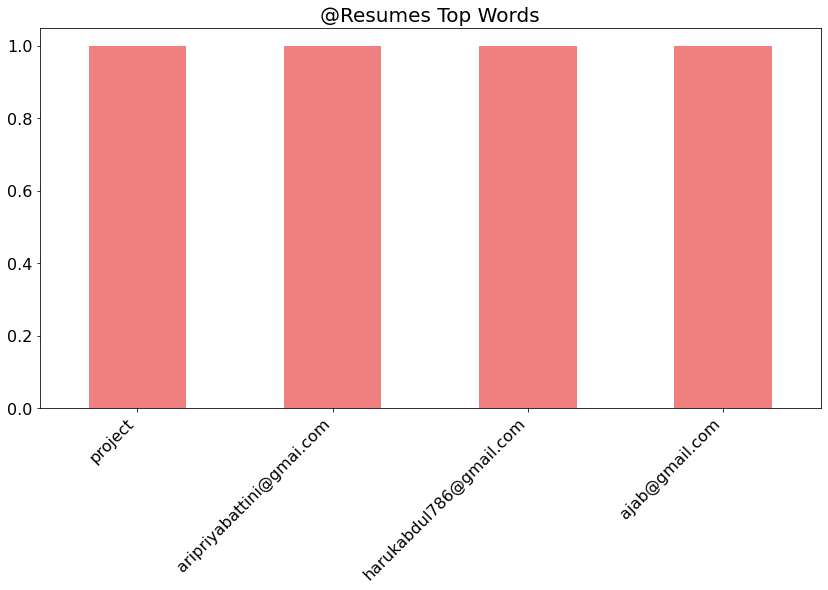

In [12]:
import itertools

c = list(
itertools.chain(
    *data.Resumes.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ") 
                            if '@' in handle.replace(":", "")]).tolist())
)

pd.Series(c).value_counts().head(20).plot.bar(
    figsize=(14, 7), fontsize=16, color='lightcoral'
)
plt.gca().set_title('@Resumes Top Words', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)

# Tokenization

In [13]:
from nltk import word_tokenize
tokens = data.Resumes.map(word_tokenize)

In [14]:
data=[Text.strip() for Text in data.Resumes] # remove both the leading and the trailing characters
data=[Text for Text in data if Text] # removes empty strings, because they are considered in Python as False
data[0:10]

['Resume Name     :  Neeraj Mishra Having 3 year  6 Month of Experience on Oracle Developer. Experience in Oracle 11g, 12c, SQL and PL/SQL programming. Experience in Creation of Tables, Indexes using SQL and PL\\SQL. Extensively worked on Backend Programming using PL/SQL  Stored Procedures, Functions, Packages, triggers, Exception Handling. Expertise in creating Oracle Tables, Views, Joins. Experience in Writing SQL Queries, Understanding Requirements. Knowledge on implementing securities using Roles, Privileges and Grants. Good Knowledge on Recursive Query Techniques, Pseudo Column implementations, SET Operators, Understanding Transaction Control, Materialized Views. Extensively worked with DDL, DML and TCL statements. Ability and willingness to learn new technology and acclimatize to any work culture. Able to adapt quickly to the environment and willing to work in shifts. I have completed B.E from RGPV Bhopal in 2013. I am working in oracle developer in Fabex tech solution pvt Ltd fr

In [15]:
review_text=' '.join(data)
review_text[:1000]

'Resume Name     :  Neeraj Mishra Having 3 year  6 Month of Experience on Oracle Developer. Experience in Oracle 11g, 12c, SQL and PL/SQL programming. Experience in Creation of Tables, Indexes using SQL and PL\\SQL. Extensively worked on Backend Programming using PL/SQL  Stored Procedures, Functions, Packages, triggers, Exception Handling. Expertise in creating Oracle Tables, Views, Joins. Experience in Writing SQL Queries, Understanding Requirements. Knowledge on implementing securities using Roles, Privileges and Grants. Good Knowledge on Recursive Query Techniques, Pseudo Column implementations, SET Operators, Understanding Transaction Control, Materialized Views. Extensively worked with DDL, DML and TCL statements. Ability and willingness to learn new technology and acclimatize to any work culture. Able to adapt quickly to the environment and willing to work in shifts. I have completed B.E from RGPV Bhopal in 2013. I am working in oracle developer in Fabex tech solution pvt Ltd fro

In [16]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
review_tokens=tknzr.tokenize(review_text)
print(review_tokens[:100])

['Resume', 'Name', ':', 'Neeraj', 'Mishra', 'Having', '3', 'year', '6', 'Month', 'of', 'Experience', 'on', 'Oracle', 'Developer', '.', 'Experience', 'in', 'Oracle', '11g', ',', '12c', ',', 'SQL', 'and', 'PL', '/', 'SQL', 'programming', '.', 'Experience', 'in', 'Creation', 'of', 'Tables', ',', 'Indexes', 'using', 'SQL', 'and', 'PL', '\\', 'SQL', '.', 'Extensively', 'worked', 'on', 'Backend', 'Programming', 'using', 'PL', '/', 'SQL', 'Stored', 'Procedures', ',', 'Functions', ',', 'Packages', ',', 'triggers', ',', 'Exception', 'Handling', '.', 'Expertise', 'in', 'creating', 'Oracle', 'Tables', ',', 'Views', ',', 'Joins', '.', 'Experience', 'in', 'Writing', 'SQL', 'Queries', ',', 'Understanding', 'Requirements', '.', 'Knowledge', 'on', 'implementing', 'securities', 'using', 'Roles', ',', 'Privileges', 'and', 'Grants', '.', 'Good', 'Knowledge', 'on', 'Recursive', 'Query']


In [17]:
review_tokens_text=' '.join(review_tokens)
review_tokens_text[:1000]

'Resume Name : Neeraj Mishra Having 3 year 6 Month of Experience on Oracle Developer . Experience in Oracle 11g , 12c , SQL and PL / SQL programming . Experience in Creation of Tables , Indexes using SQL and PL \\ SQL . Extensively worked on Backend Programming using PL / SQL Stored Procedures , Functions , Packages , triggers , Exception Handling . Expertise in creating Oracle Tables , Views , Joins . Experience in Writing SQL Queries , Understanding Requirements . Knowledge on implementing securities using Roles , Privileges and Grants . Good Knowledge on Recursive Query Techniques , Pseudo Column implementations , SET Operators , Understanding Transaction Control , Materialized Views . Extensively worked with DDL , DML and TCL statements . Ability and willingness to learn new technology and acclimatize to any work culture . Able to adapt quickly to the environment and willing to work in shifts . I have completed B . E from RGPV Bhopal in 2013 . I am working in oracle developer in Fa

# Remove Punchuation From Text

In [18]:
no_punc_text=review_tokens_text.translate(str.maketrans('','',string.punctuation))
no_punc_text[:1000]

'Resume Name  Neeraj Mishra Having 3 year 6 Month of Experience on Oracle Developer  Experience in Oracle 11g  12c  SQL and PL  SQL programming  Experience in Creation of Tables  Indexes using SQL and PL  SQL  Extensively worked on Backend Programming using PL  SQL Stored Procedures  Functions  Packages  triggers  Exception Handling  Expertise in creating Oracle Tables  Views  Joins  Experience in Writing SQL Queries  Understanding Requirements  Knowledge on implementing securities using Roles  Privileges and Grants  Good Knowledge on Recursive Query Techniques  Pseudo Column implementations  SET Operators  Understanding Transaction Control  Materialized Views  Extensively worked with DDL  DML and TCL statements  Ability and willingness to learn new technology and acclimatize to any work culture  Able to adapt quickly to the environment and willing to work in shifts  I have completed B  E from RGPV Bhopal in 2013  I am working in oracle developer in Fabex tech solution pvt Ltd from 201

# Remove URL'S from Text

In [19]:
no_url_text=re.sub(r'http\S+', '', no_punc_text)
no_url_text[:1000]

'Resume Name  Neeraj Mishra Having 3 year 6 Month of Experience on Oracle Developer  Experience in Oracle 11g  12c  SQL and PL  SQL programming  Experience in Creation of Tables  Indexes using SQL and PL  SQL  Extensively worked on Backend Programming using PL  SQL Stored Procedures  Functions  Packages  triggers  Exception Handling  Expertise in creating Oracle Tables  Views  Joins  Experience in Writing SQL Queries  Understanding Requirements  Knowledge on implementing securities using Roles  Privileges and Grants  Good Knowledge on Recursive Query Techniques  Pseudo Column implementations  SET Operators  Understanding Transaction Control  Materialized Views  Extensively worked with DDL  DML and TCL statements  Ability and willingness to learn new technology and acclimatize to any work culture  Able to adapt quickly to the environment and willing to work in shifts  I have completed B  E from RGPV Bhopal in 2013  I am working in oracle developer in Fabex tech solution pvt Ltd from 201

# Apply Tokenization on 100 Words

In [20]:
import nltk.data
from nltk.tokenize import word_tokenize
text_tokens=word_tokenize(no_url_text)
print(text_tokens[:100])

['Resume', 'Name', 'Neeraj', 'Mishra', 'Having', '3', 'year', '6', 'Month', 'of', 'Experience', 'on', 'Oracle', 'Developer', 'Experience', 'in', 'Oracle', '11g', '12c', 'SQL', 'and', 'PL', 'SQL', 'programming', 'Experience', 'in', 'Creation', 'of', 'Tables', 'Indexes', 'using', 'SQL', 'and', 'PL', 'SQL', 'Extensively', 'worked', 'on', 'Backend', 'Programming', 'using', 'PL', 'SQL', 'Stored', 'Procedures', 'Functions', 'Packages', 'triggers', 'Exception', 'Handling', 'Expertise', 'in', 'creating', 'Oracle', 'Tables', 'Views', 'Joins', 'Experience', 'in', 'Writing', 'SQL', 'Queries', 'Understanding', 'Requirements', 'Knowledge', 'on', 'implementing', 'securities', 'using', 'Roles', 'Privileges', 'and', 'Grants', 'Good', 'Knowledge', 'on', 'Recursive', 'Query', 'Techniques', 'Pseudo', 'Column', 'implementations', 'SET', 'Operators', 'Understanding', 'Transaction', 'Control', 'Materialized', 'Views', 'Extensively', 'worked', 'with', 'DDL', 'DML', 'and', 'TCL', 'statements', 'Ability', 'and

In [21]:
len(text_tokens)

55383

# Removing Stopwords

In [22]:
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')

no_stop_tokens=[word for word in text_tokens if not word in my_stop_words]
print(no_stop_tokens[:100])

['Resume', 'Name', 'Neeraj', 'Mishra', 'Having', '3', 'year', '6', 'Month', 'Experience', 'Oracle', 'Developer', 'Experience', 'Oracle', '11g', '12c', 'SQL', 'PL', 'SQL', 'programming', 'Experience', 'Creation', 'Tables', 'Indexes', 'using', 'SQL', 'PL', 'SQL', 'Extensively', 'worked', 'Backend', 'Programming', 'using', 'PL', 'SQL', 'Stored', 'Procedures', 'Functions', 'Packages', 'triggers', 'Exception', 'Handling', 'Expertise', 'creating', 'Oracle', 'Tables', 'Views', 'Joins', 'Experience', 'Writing', 'SQL', 'Queries', 'Understanding', 'Requirements', 'Knowledge', 'implementing', 'securities', 'using', 'Roles', 'Privileges', 'Grants', 'Good', 'Knowledge', 'Recursive', 'Query', 'Techniques', 'Pseudo', 'Column', 'implementations', 'SET', 'Operators', 'Understanding', 'Transaction', 'Control', 'Materialized', 'Views', 'Extensively', 'worked', 'DDL', 'DML', 'TCL', 'statements', 'Ability', 'willingness', 'learn', 'new', 'technology', 'acclimatize', 'work', 'culture', 'Able', 'adapt', 'qui

In [23]:
lower_words=[Text.lower() for Text in no_stop_tokens]
print(lower_words[:100])

['resume', 'name', 'neeraj', 'mishra', 'having', '3', 'year', '6', 'month', 'experience', 'oracle', 'developer', 'experience', 'oracle', '11g', '12c', 'sql', 'pl', 'sql', 'programming', 'experience', 'creation', 'tables', 'indexes', 'using', 'sql', 'pl', 'sql', 'extensively', 'worked', 'backend', 'programming', 'using', 'pl', 'sql', 'stored', 'procedures', 'functions', 'packages', 'triggers', 'exception', 'handling', 'expertise', 'creating', 'oracle', 'tables', 'views', 'joins', 'experience', 'writing', 'sql', 'queries', 'understanding', 'requirements', 'knowledge', 'implementing', 'securities', 'using', 'roles', 'privileges', 'grants', 'good', 'knowledge', 'recursive', 'query', 'techniques', 'pseudo', 'column', 'implementations', 'set', 'operators', 'understanding', 'transaction', 'control', 'materialized', 'views', 'extensively', 'worked', 'ddl', 'dml', 'tcl', 'statements', 'ability', 'willingness', 'learn', 'new', 'technology', 'acclimatize', 'work', 'culture', 'able', 'adapt', 'qui

# Applying Stemming

In [24]:
from nltk.stem import PorterStemmer
ps=PorterStemmer()
stemmed_tokens=[ps.stem(word) for word in lower_words]
print(stemmed_tokens[:100])

['resum', 'name', 'neeraj', 'mishra', 'have', '3', 'year', '6', 'month', 'experi', 'oracl', 'develop', 'experi', 'oracl', '11g', '12c', 'sql', 'pl', 'sql', 'program', 'experi', 'creation', 'tabl', 'index', 'use', 'sql', 'pl', 'sql', 'extens', 'work', 'backend', 'program', 'use', 'pl', 'sql', 'store', 'procedur', 'function', 'packag', 'trigger', 'except', 'handl', 'expertis', 'creat', 'oracl', 'tabl', 'view', 'join', 'experi', 'write', 'sql', 'queri', 'understand', 'requir', 'knowledg', 'implement', 'secur', 'use', 'role', 'privileg', 'grant', 'good', 'knowledg', 'recurs', 'queri', 'techniqu', 'pseudo', 'column', 'implement', 'set', 'oper', 'understand', 'transact', 'control', 'materi', 'view', 'extens', 'work', 'ddl', 'dml', 'tcl', 'statement', 'abil', 'willing', 'learn', 'new', 'technolog', 'acclimat', 'work', 'cultur', 'abl', 'adapt', 'quickli', 'environ', 'will', 'work', 'shift', 'i', 'complet', 'b']


In [25]:
nlp=spacy.load('en_core_web_sm')
doc=nlp(' '.join(lower_words))
print(doc[:100])

resume name neeraj mishra having 3 year 6 month experience oracle developer experience oracle 11g 12c sql pl sql programming experience creation tables indexes using sql pl sql extensively worked backend programming using pl sql stored procedures functions packages triggers exception handling expertise creating oracle tables views joins experience writing sql queries understanding requirements knowledge implementing securities using roles privileges grants good knowledge recursive query techniques pseudo column implementations set operators understanding transaction control materialized views extensively worked ddl dml tcl statements ability willingness learn new technology acclimatize work culture able adapt quickly environment willing work shifts i completed


# Applying Lemmatization

In [26]:
lemmas=[token.lemma_ for token in doc]
print(lemmas[:100])

['resume', 'name', 'neeraj', 'mishra', 'have', '3', 'year', '6', 'month', 'experience', 'oracle', 'developer', 'experience', 'oracle', '11', 'g', '12c', 'sql', 'pl', 'sql', 'programming', 'experience', 'creation', 'table', 'index', 'use', 'sql', 'pl', 'sql', 'extensively', 'work', 'backend', 'programming', 'use', 'pl', 'sql', 'store', 'procedure', 'function', 'package', 'trigger', 'exception', 'handling', 'expertise', 'create', 'oracle', 'table', 'view', 'join', 'experience', 'write', 'sql', 'query', 'understanding', 'requirement', 'knowledge', 'implement', 'security', 'use', 'role', 'privilege', 'grant', 'good', 'knowledge', 'recursive', 'query', 'technique', 'pseudo', 'column', 'implementation', 'set', 'operator', 'understand', 'transaction', 'control', 'materialize', 'view', 'extensively', 'work', 'ddl', 'dml', 'tcl', 'statement', 'ability', 'willingness', 'learn', 'new', 'technology', 'acclimatize', 'work', 'culture', 'able', 'adapt', 'quickly', 'environment', 'willing', 'work', 's

In [27]:
clean_review=' '.join(lemmas)
clean_review[:1000]

'resume name neeraj mishra have 3 year 6 month experience oracle developer experience oracle 11 g 12c sql pl sql programming experience creation table index use sql pl sql extensively work backend programming use pl sql store procedure function package trigger exception handling expertise create oracle table view join experience write sql query understanding requirement knowledge implement security use role privilege grant good knowledge recursive query technique pseudo column implementation set operator understand transaction control materialize view extensively work ddl dml tcl statement ability willingness learn new technology acclimatize work culture able adapt quickly environment willing work shift I complete b e rgpv bhopal 2013 I work oracle developer fabex tech solution pvt ltd 2017 till operate system window database oracle 11 g 18c programming language sql pl sql unix technical skill oracle sql pl sql tool sql developer crm sql loader environment oracle 11 g window project na

# Applying Text Processing On DataFrame

In [29]:
data = pd.read_csv("/content/resumes.csv")

In [30]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

# Converting Into Clean Resumes

In [31]:
data['Clean_Resumes'] = np.vectorize(remove_pattern)(data['Resumes'], "@[\w]*")
data.head(10)

,Resumes,Category,Clean_Resumes
0,Resu...,DBM,Resu...
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer,"C O N T A C T : Address: Manyata Tech Park, Na..."
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer,Naveen Sadhu Title: software developer\t\t\t\t...
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer,Pranish Sonone \t Career summary: Experience o...
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday,\t Name : Gopi Krishna Reddy \t\t ...
5,resume Ram...,Analyst,resume Ram...
6,KAMBALA SAI SURENDRA \tMandepeta \t ...,Student,KAMBALA SAI SURENDRA \tMandepeta \t ...
7,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...,Frontend Developer,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...
8,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...,Workday,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...
9," 204,Sri geethika prestige,road number 10,ban...",Analyst," 204,Sri geethika prestige,road number 10,ban..."


# Remove Url from Clean_Resumes

In [32]:
clean_Resumes = []

for index, row in data.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Clean_Resumes.split() if 'http' not in word]
    clean_Resumes.append(' '.join(words_without_links))

data['Clean_Resumes'] = clean_Resumes
data.head(10)

,Resumes,Category,Clean_Resumes
0,Resu...,DBM,Resume Name : Neeraj Mishra Having 3 year 6 Mo...
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer,"C O N T A C T : Address: Manyata Tech Park, Na..."
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer,Naveen Sadhu Title: software developer Locatio...
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer,Pranish Sonone Career summary: Experience of 1...
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday,Name : Gopi Krishna Reddy PROFESSIONAL SUMMERY...
5,resume Ram...,Analyst,resume Ramalakshmi K Career Objective : Profes...
6,KAMBALA SAI SURENDRA \tMandepeta \t ...,Student,KAMBALA SAI SURENDRA Mandepeta SUMMARY Project...
7,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...,Frontend Developer,MD KHIZARUDDIN RAUF EXPERIENCE ⇨ Currently wor...
8,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...,Workday,WORKDAY | HCM | FCM Name : Kumar S.S Role : Wo...
9," 204,Sri geethika prestige,road number 10,ban...",Analyst," 204,Sri geethika prestige,road number 10,ban..."


# Remove '!' from Clean_Resumes

In [33]:
data = data[data['Clean_Resumes']!='']
data.head(10)

,Resumes,Category,Clean_Resumes
0,Resu...,DBM,Resume Name : Neeraj Mishra Having 3 year 6 Mo...
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer,"C O N T A C T : Address: Manyata Tech Park, Na..."
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer,Naveen Sadhu Title: software developer Locatio...
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer,Pranish Sonone Career summary: Experience of 1...
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday,Name : Gopi Krishna Reddy PROFESSIONAL SUMMERY...
5,resume Ram...,Analyst,resume Ramalakshmi K Career Objective : Profes...
6,KAMBALA SAI SURENDRA \tMandepeta \t ...,Student,KAMBALA SAI SURENDRA Mandepeta SUMMARY Project...
7,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...,Frontend Developer,MD KHIZARUDDIN RAUF EXPERIENCE ⇨ Currently wor...
8,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...,Workday,WORKDAY | HCM | FCM Name : Kumar S.S Role : Wo...
9," 204,Sri geethika prestige,road number 10,ban...",Analyst," 204,Sri geethika prestige,road number 10,ban..."


# Removing Duplicate Resumes

In [34]:
data.drop_duplicates(subset=['Clean_Resumes'], keep=False)
data.head(10)

,Resumes,Category,Clean_Resumes
0,Resu...,DBM,Resume Name : Neeraj Mishra Having 3 year 6 Mo...
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer,"C O N T A C T : Address: Manyata Tech Park, Na..."
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer,Naveen Sadhu Title: software developer Locatio...
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer,Pranish Sonone Career summary: Experience of 1...
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday,Name : Gopi Krishna Reddy PROFESSIONAL SUMMERY...
5,resume Ram...,Analyst,resume Ramalakshmi K Career Objective : Profes...
6,KAMBALA SAI SURENDRA \tMandepeta \t ...,Student,KAMBALA SAI SURENDRA Mandepeta SUMMARY Project...
7,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...,Frontend Developer,MD KHIZARUDDIN RAUF EXPERIENCE ⇨ Currently wor...
8,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...,Workday,WORKDAY | HCM | FCM Name : Kumar S.S Role : Wo...
9," 204,Sri geethika prestige,road number 10,ban...",Analyst," 204,Sri geethika prestige,road number 10,ban..."


In [35]:
data = data.reset_index(drop=True)
data.head(10)

,Resumes,Category,Clean_Resumes
0,Resu...,DBM,Resume Name : Neeraj Mishra Having 3 year 6 Mo...
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer,"C O N T A C T : Address: Manyata Tech Park, Na..."
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer,Naveen Sadhu Title: software developer Locatio...
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer,Pranish Sonone Career summary: Experience of 1...
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday,Name : Gopi Krishna Reddy PROFESSIONAL SUMMERY...
5,resume Ram...,Analyst,resume Ramalakshmi K Career Objective : Profes...
6,KAMBALA SAI SURENDRA \tMandepeta \t ...,Student,KAMBALA SAI SURENDRA Mandepeta SUMMARY Project...
7,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...,Frontend Developer,MD KHIZARUDDIN RAUF EXPERIENCE ⇨ Currently wor...
8,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...,Workday,WORKDAY | HCM | FCM Name : Kumar S.S Role : Wo...
9," 204,Sri geethika prestige,road number 10,ban...",Analyst," 204,Sri geethika prestige,road number 10,ban..."


# Cleaning Words From Text

In [36]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('!', '',text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('⇨', '',text)
    text = re.sub(':', '',text)
    text = re.sub('•', '',text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [37]:
data['Clean_Resumes'] = data['Clean_Resumes'].apply(lambda x: clean_text(x))
data.head(10)

,Resumes,Category,Clean_Resumes
0,Resu...,DBM,resume name neeraj mishra having year month...
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer,c o n t a c t address manyata tech park nagav...
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer,naveen sadhu title software developer location...
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer,pranish sonone career summary experience of y...
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday,name gopi krishna reddy professional summery ...
5,resume Ram...,Analyst,resume ramalakshmi k career objective profess...
6,KAMBALA SAI SURENDRA \tMandepeta \t ...,Student,kambala sai surendra mandepeta summary ma ed...
7,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...,Frontend Developer,md khizaruddin rauf experience currently work...
8,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...,Workday,workday hcm fcm name kumar ss role workday...
9," 204,Sri geethika prestige,road number 10,ban...",Analyst, geethika prestigeroad number having year...


# Removing Emoji from Clean_Resumes

In [38]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [39]:
data['Clean_Resumes']=data['Clean_Resumes'].apply(lambda x: remove_emoji(x))
data.head(10)

,Resumes,Category,Clean_Resumes
0,Resu...,DBM,resume name neeraj mishra having year month...
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer,c o n t a c t address manyata tech park nagav...
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer,naveen sadhu title software developer location...
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer,pranish sonone career summary experience of y...
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday,name gopi krishna reddy professional summery ...
5,resume Ram...,Analyst,resume ramalakshmi k career objective profess...
6,KAMBALA SAI SURENDRA \tMandepeta \t ...,Student,kambala sai surendra mandepeta summary ma ed...
7,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...,Frontend Developer,md khizaruddin rauf experience currently work...
8,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...,Workday,workday hcm fcm name kumar ss role workday...
9," 204,Sri geethika prestige,road number 10,ban...",Analyst,geethika prestigeroad number having years...


# Applying Tokenization On Clean_Resumes

In [40]:
data['Tokenized_Resumes'] = data['Clean_Resumes'].apply(lambda x: nltk.word_tokenize(x))
data.head(10)

,Resumes,Category,Clean_Resumes,Tokenized_Resumes
0,Resu...,DBM,resume name neeraj mishra having year month...,"[resume, name, neeraj, mishra, having, year, m..."
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer,c o n t a c t address manyata tech park nagav...,"[c, o, n, t, a, c, t, address, manyata, tech, ..."
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer,naveen sadhu title software developer location...,"[naveen, sadhu, title, software, developer, lo..."
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer,pranish sonone career summary experience of y...,"[pranish, sonone, career, summary, experience,..."
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday,name gopi krishna reddy professional summery ...,"[name, gopi, krishna, reddy, professional, sum..."
5,resume Ram...,Analyst,resume ramalakshmi k career objective profess...,"[resume, ramalakshmi, k, career, objective, pr..."
6,KAMBALA SAI SURENDRA \tMandepeta \t ...,Student,kambala sai surendra mandepeta summary ma ed...,"[kambala, sai, surendra, mandepeta, summary, m..."
7,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...,Frontend Developer,md khizaruddin rauf experience currently work...,"[md, khizaruddin, rauf, experience, currently,..."
8,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...,Workday,workday hcm fcm name kumar ss role workday...,"[workday, hcm, fcm, name, kumar, ss, role, wor..."
9," 204,Sri geethika prestige,road number 10,ban...",Analyst,geethika prestigeroad number having years...,"[geethika, prestigeroad, number, having, years..."


In [41]:
data.drop(['Tokenized_Resumes'],axis=1,inplace=True)

# Removing stop words from Clean_Resumes and Making it Absolutely_Clean_Resumes

In [42]:
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')
cleaned_resumes = []
for index, row in data.iterrows():
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.Clean_Resumes.split()]
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_resumes.append(' '.join(words_without_stopwords))
data['Absolute_Clean_Resumes'] = cleaned_resumes
data.head(10)

,Resumes,Category,Clean_Resumes,Absolute_Clean_Resumes
0,Resu...,DBM,resume name neeraj mishra having year month...,resume name neeraj mishra having year month of...
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer,c o n t a c t address manyata tech park nagav...,c o n t a c t address manyata tech park nagava...
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer,naveen sadhu title software developer location...,naveen sadhu title software developer location...
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer,pranish sonone career summary experience of y...,pranish sonone career summary experience of ye...
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday,name gopi krishna reddy professional summery ...,name gopi krishna reddy professional summery w...
5,resume Ram...,Analyst,resume ramalakshmi k career objective profess...,resume ramalakshmi k career objective professi...
6,KAMBALA SAI SURENDRA \tMandepeta \t ...,Student,kambala sai surendra mandepeta summary ma ed...,kambala sai surendra mandepeta summary ma educ...
7,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...,Frontend Developer,md khizaruddin rauf experience currently work...,md khizaruddin rauf experience currently worki...
8,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...,Workday,workday hcm fcm name kumar ss role workday...,workday hcm fcm name kumar ss role workday con...
9," 204,Sri geethika prestige,road number 10,ban...",Analyst,geethika prestigeroad number having years...,geethika prestigeroad number having years of e...


In [43]:
Tokenized_Resume = data['Absolute_Clean_Resumes'].apply(lambda x: x.split())
Tokenized_Resume.head(10)

0    [resume, name, neeraj, mishra, having, year, m...
1    [c, o, n, t, a, c, t, address, manyata, tech, ...
2    [naveen, sadhu, title, software, developer, lo...
3    [pranish, sonone, career, summary, experience,...
4    [name, gopi, krishna, reddy, professional, sum...
5    [resume, ramalakshmi, k, career, objective, pr...
6    [kambala, sai, surendra, mandepeta, summary, m...
7    [md, khizaruddin, rauf, experience, currently,...
8    [workday, hcm, fcm, name, kumar, ss, role, wor...
9    [geethika, prestigeroad, number, having, years...
Name: Absolute_Clean_Resumes, dtype: object

# Applying Lemmatization on Abosulte_Clean_Resumes

In [44]:
word_lemmatizer = WordNetLemmatizer()
nltk.download('omw-1.4')

Tokenized_Resumes = Tokenized_Resume.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
Tokenized_Resumes.head(10)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


0    [resume, name, neeraj, mishra, having, year, m...
1    [c, o, n, t, a, c, t, address, manyata, tech, ...
2    [naveen, sadhu, title, software, developer, lo...
3    [pranish, sonone, career, summary, experience,...
4    [name, gopi, krishna, reddy, professional, sum...
5    [resume, ramalakshmi, k, career, objective, pr...
6    [kambala, sai, surendra, mandepeta, summary, m...
7    [md, khizaruddin, rauf, experience, currently,...
8    [workday, hcm, fcm, name, kumar, s, role, work...
9    [geethika, prestigeroad, number, having, year,...
Name: Absolute_Clean_Resumes, dtype: object

In [45]:
for i, tokens in enumerate(Tokenized_Resume):
    Tokenized_Resume[i] = ' '.join(tokens)

data['Absolute_Clean_Resumes'] = Tokenized_Resume
data.head(10)

,Resumes,Category,Clean_Resumes,Absolute_Clean_Resumes
0,Resu...,DBM,resume name neeraj mishra having year month...,resume name neeraj mishra having year month of...
1,"C O N T A C T : Address: Manyata Tech Park, Na...",Frontend Developer,c o n t a c t address manyata tech park nagav...,c o n t a c t address manyata tech park nagava...
2,Naveen Sadhu Title: software developer\t\t\t\t...,Frontend Developer,naveen sadhu title software developer location...,naveen sadhu title software developer location...
3,Pranish Sonone \t Career summary: Experience o...,Frontend Developer,pranish sonone career summary experience of y...,pranish sonone career summary experience of ye...
4,\t Name : Gopi Krishna Reddy \t\t ...,Workday,name gopi krishna reddy professional summery ...,name gopi krishna reddy professional summery w...
5,resume Ram...,Analyst,resume ramalakshmi k career objective profess...,resume ramalakshmi k career objective professi...
6,KAMBALA SAI SURENDRA \tMandepeta \t ...,Student,kambala sai surendra mandepeta summary ma ed...,kambala sai surendra mandepeta summary ma educ...
7,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ C...,Frontend Developer,md khizaruddin rauf experience currently work...,md khizaruddin rauf experience currently worki...
8,WORKDAY | HCM | FCM Name \t\t: Kumar S.S Role ...,Workday,workday hcm fcm name kumar ss role workday...,workday hcm fcm name kumar ss role workday con...
9," 204,Sri geethika prestige,road number 10,ban...",Analyst,geethika prestigeroad number having years...,geethika prestigeroad number having years of e...


# Applying Count Vectorizer

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
review_cv=cv.fit_transform(lemmas)

In [47]:
print(cv.get_feature_names()[100:2000])

['2001', '200112014', '2003', '20032008', '2005', '2006', '2007', '20072008', '2008', '20082012', '2008r2', '2009', '20092011', '20092013', '2010', '2011', '20112015', '2012', '20122014', '20122016', '2012r2', '2013', '2014', '20142012', '20142016', '20142017', '2015', '20152017', '2016', '20162012', '2016r2', '2017', '20172019', '201784006', '2018', '2019', '2019to', '2020', '2021', '2022', '204', '21', '210', '211', '22', '2208', '23', '2301', '24', '247', '25', '26', '2601', '2627', '26387', '2705', '2728', '27th', '28', '281121', '2930', '2k15', '2k16', '2k18', '30', '300', '3015', '3031', '31', '310', '32', '3233', '33', '34', '35', '36', '360', '364445', '365', '37', '38', '39', '3year', '401', '401k', '41', '411', '42', '43', '44', '46', '49600', '498', '50', '500090', '508', '51', '518', '52', '528', '53', '5312', '538', '53854', '54', '5455', '548', '55', '558', '56', '560045', '57', '5770q', '578', '58', '5th', '605', '61', '610', '612', '6126', '6146', '62', '63', '6380', '6

In [48]:
print(cv.get_feature_names()[:4000])

['006', '01', '012019', '0144b', '016', '017', '022019', '032', '032012', '032014', '032018', '032019', '032020', '032021', '04', '0411', '042019', '042021', '04th', '05', '0509', '052015', '052018', '052021', '05th', '06', '062019', '06th', '07', '072017', '07th', '08', '082011', '082012', '082014', '082018', '082020', '09', '092015', '092020', '10', '100', '1011', '1013', '102', '103', '104236', '106', '109', '10gr2', '10gr3', '10gr3and', '10th', '11', '112', '112013', '1131', '11gr2', '11i', '11th', '12', '121', '122', '122020', '12c', '12cr1', '12cr2', '12th', '13', '13000', '14', '15', '1502', '16', '16698139', '17', '1713', '17329', '18', '188', '18c', '19', '19000', '1904', '197174', '1985', '1987', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1st', '20', '200', '2000', '20002003', '2001', '200112014', '2003', '20032008', '2005', '2006', '2007', '20072008', '2008', '20082012', '2008r2', '2009', '20092011', '20092013', '2010', '2011', '20112015', '2012', '2012

In [49]:
print(review_cv.toarray()[100:2000])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [50]:
print(review_cv.toarray().shape)

(43150, 4175)


# Applyong Count vectorizer on NGrams

In [51]:
cv_ngram_range=CountVectorizer(analyzer='word',ngram_range=(1,3),max_features=4000)
bow_matrix_ngram=cv_ngram_range.fit_transform(lemmas)

In [52]:
print(cv_ngram_range.get_feature_names())
print(bow_matrix_ngram.toarray())

['006', '01', '012019', '0144b', '016', '017', '022019', '032', '032012', '032014', '032018', '032019', '032020', '032021', '04', '0411', '042019', '042021', '04th', '05', '0509', '052015', '052018', '052021', '05th', '06', '062019', '06th', '07', '072017', '07th', '08', '082011', '082012', '082014', '082018', '082020', '09', '092015', '092020', '10', '100', '1011', '1013', '102', '103', '104236', '106', '109', '10gr2', '10gr3', '10gr3and', '10th', '11', '112', '112013', '1131', '11gr2', '11i', '11th', '12', '121', '122', '122020', '12c', '12cr1', '12cr2', '12th', '13', '13000', '14', '15', '1502', '16', '16698139', '17', '1713', '17329', '18', '188', '18c', '19', '19000', '1904', '197174', '1985', '1987', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1st', '20', '200', '2000', '20002003', '2001', '200112014', '2003', '20032008', '2005', '2006', '2007', '20072008', '2008', '20082012', '2008r2', '2009', '20092011', '20092013', '2010', '2011', '20112015', '2012', '2012

In [53]:
data.drop(['Resumes','Clean_Resumes'],axis=1,inplace=True)

In [54]:
data

,Category,Absolute_Clean_Resumes
0,DBM,resume name neeraj mishra having year month of...
1,Frontend Developer,c o n t a c t address manyata tech park nagava...
2,Frontend Developer,naveen sadhu title software developer location...
3,Frontend Developer,pranish sonone career summary experience of ye...
4,Workday,name gopi krishna reddy professional summery w...
...,...,...
74,Frontend Developer,maryala vinay reddy professional summary · hav...
75,Analyst,deepchand curriculum vitae anjani priyadarshin...
76,Peoplesoft,rahul ahuja summary · years of experience in p...
77,Workday,hari krishna m summary · a result oriented pro...


In [55]:
import string
from nltk.corpus import stopwords
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = data['Absolute_Clean_Resumes'].values
cleanedSentences = ""
for records in Sentences:
    cleanedSentences += records
    requiredWords = nltk.word_tokenize(records)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(100)
print(mostcommon)

[('·', 1387), ('experience', 576), ('peoplesoft', 432), ('application', 395), ('workday', 390), ('using', 383), ('server', 331), ('data', 318), ('reports', 316), ('project', 290), ('business', 260), ('process', 230), ('database', 226), ('web', 223), ('worked', 219), ('sql', 214), ('knowledge', 205), ('involved', 187), ('integrations', 186), ('client', 183), ('like', 179), ('integration', 175), ('tools', 172), ('support', 172), ('system', 171), ('good', 164), ('creating', 160), ('development', 160), ('hcm', 158), ('working', 156), ('team', 156), ('technical', 153), ('skills', 152), ('design', 150), ('people', 150), ('testing', 149), ('servers', 149), ('created', 145), ('various', 144), ('responsibilities', 142), ('report', 141), ('services', 135), ('environment', 134), ('production', 130), ('issues', 128), ('management', 125), ('security', 125), ('oracle', 124), ('role', 124), ('work', 122), ('’', 122), ('developer', 121), ('eib', 119), ('custom', 117), ('studio', 116), ('domains', 115)

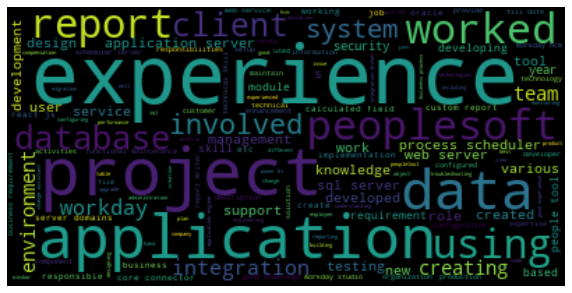

In [56]:
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [57]:
categories = np.sort(data['Category'].unique())
categories

array(['Analyst', 'DBM', 'Frontend Developer', 'Peoplesoft', 'Student',
       'Workday'], dtype=object)

In [58]:
data_categories = [data[data['Category'] == category].loc[:, ['Absolute_Clean_Resumes', 'Category']] for category in categories]
data_categories

[                               Absolute_Clean_Resumes Category
 5   resume ramalakshmi k career objective professi...  Analyst
 9   geethika prestigeroad number having years of e...  Analyst
 12  kanumuru deepak reddy career objective to secu...  Analyst
 18  aradhana tripathi current location gachibowli ...  Analyst
 32  pragnya pattnaik expertise having around years...  Analyst
 33  kotani durga prasad objective aspirant for a p...  Analyst
 37  susovan bag seeking a challenging position in ...  Analyst
 41  kamalakar reddy a linked in professional summa...  Analyst
 59  hyderabad nazeer basha sql and power bi develo...  Analyst
 75  deepchand curriculum vitae anjani priyadarshin...  Analyst
 78  page name m prabakaran title ui developer prof...  Analyst,
                                Absolute_Clean_Resumes Category
 0   resume name neeraj mishra having year month of...      DBM
 19  sql developer name bandi prem sai willing to w...      DBM
 25  kamballa pradeep synopsis looking 

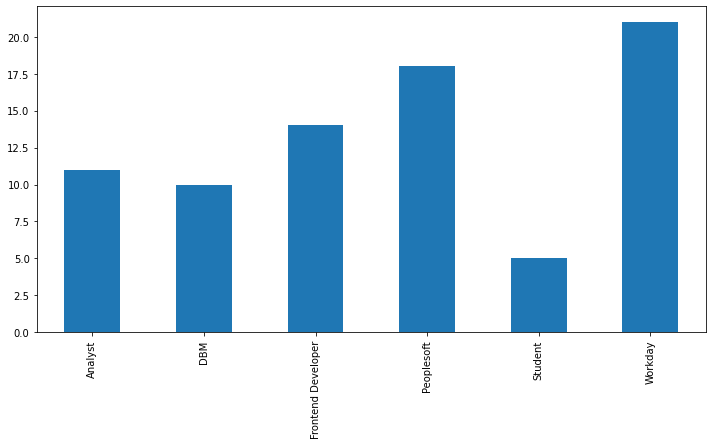

In [59]:
data['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.show()

In [60]:
def wordcloud(df):
    txt = ' '.join(txt for txt in data['Absolute_Clean_Resumes'])
    wordcloud = WordCloud(
        height=2000,
        width=4000,
        colormap=WORDCLOUD_COLOR_MAP
    ).generate(txt)

    return wordcloud

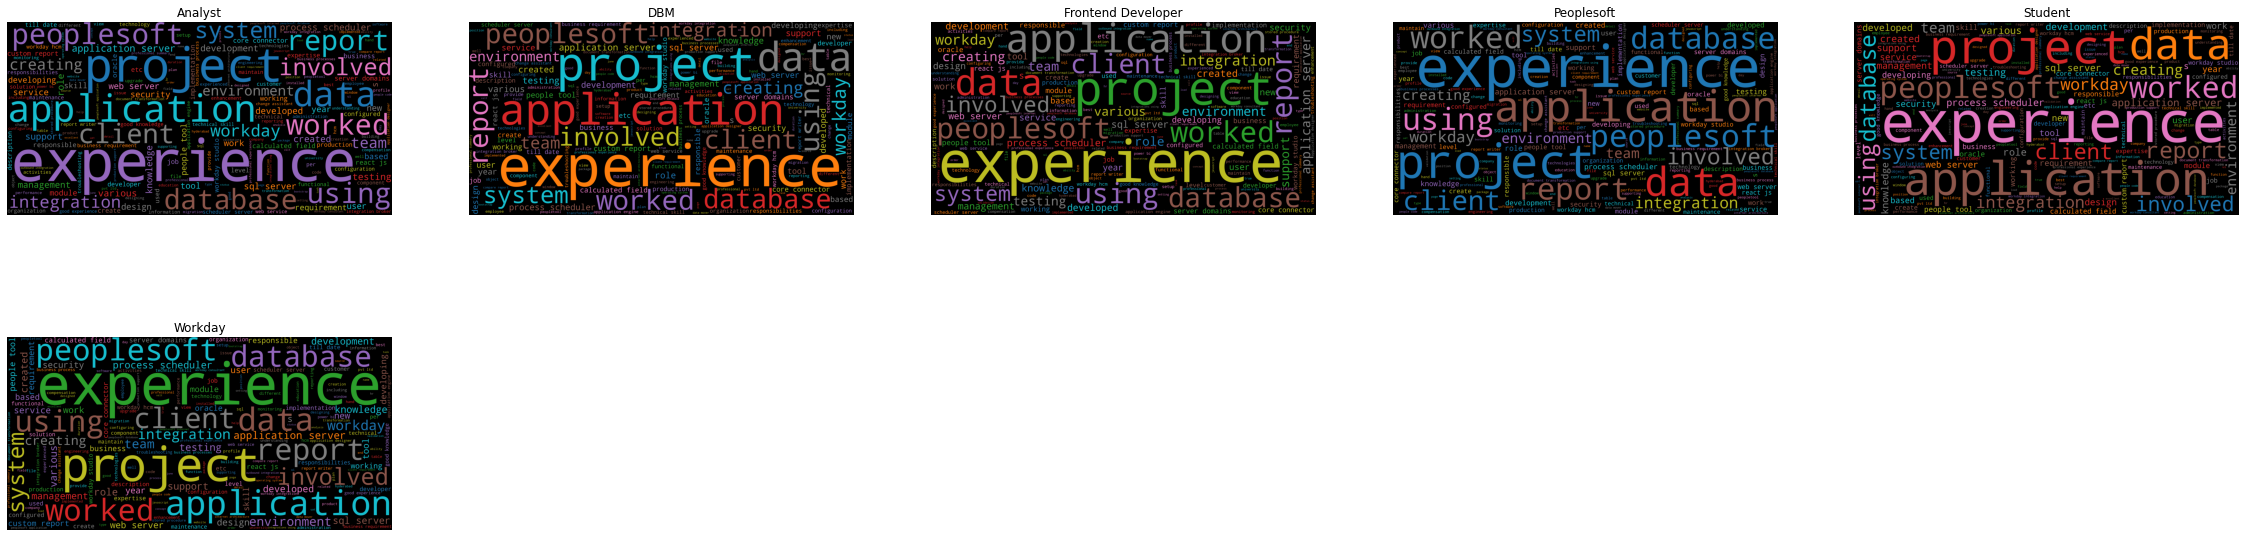

In [61]:
# for other theme, please run: mpl.pyplot.style.available
PLOT_PALETTE = 'tableau-colorblind10'
# for other color map, please run: mpl.pyplot.colormaps()
WORDCLOUD_COLOR_MAP = 'tab10_r'
plt.style.use(PLOT_PALETTE)
%matplotlib inline
plt.figure(figsize=(40, 28))

for i, category in enumerate(categories):
    wc = wordcloud(data_categories[i])

    plt.subplot(5, 5, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

In [62]:
def wordfreq(df):
    count = data['Absolute_Clean_Resumes'].str.split(expand=True).stack().value_counts().reset_index()
    count.columns = ['Word', 'Frequency']

    return count.head(10)

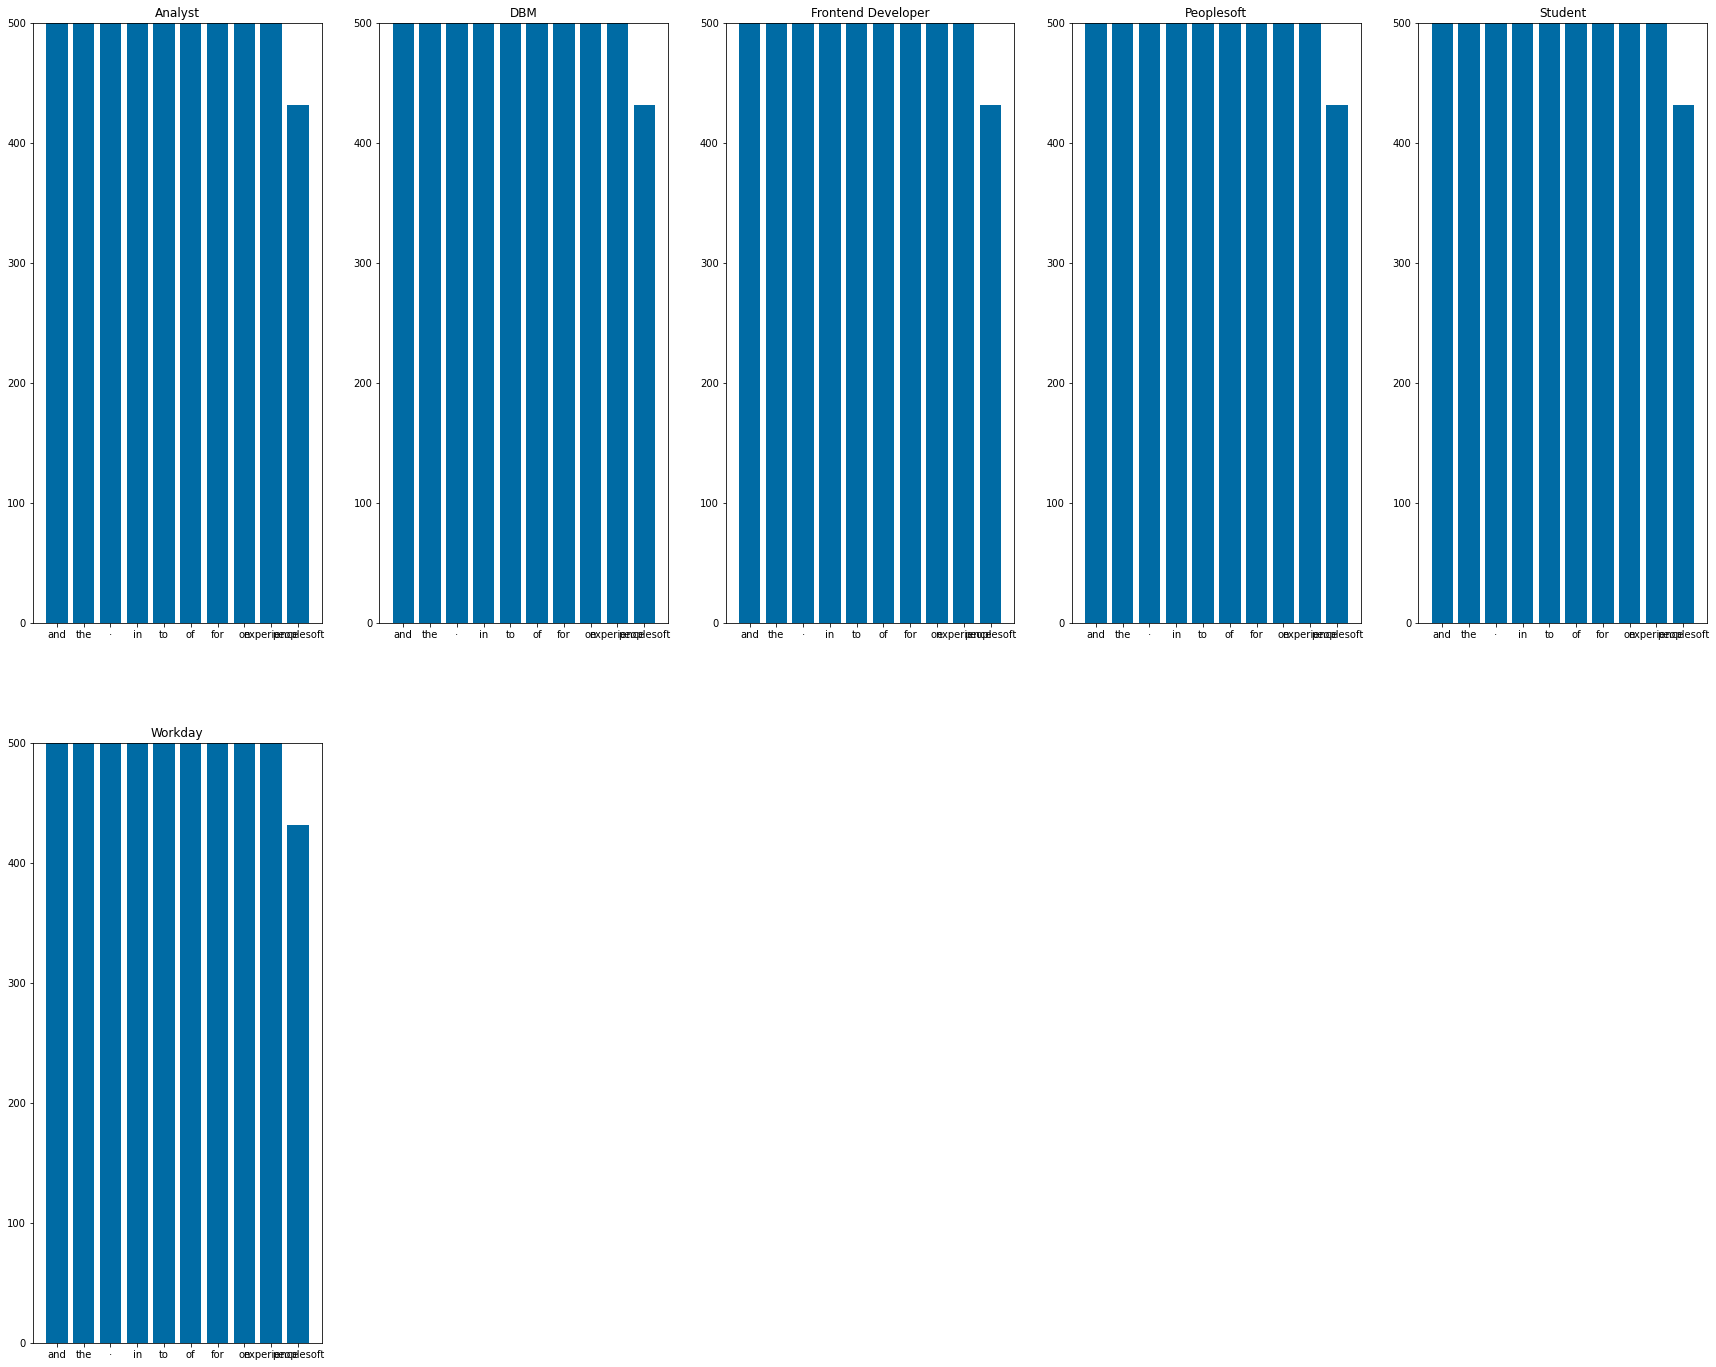

In [63]:
fig = plt.figure(figsize=(30, 64))

for i, category in enumerate(categories):
    wf = wordfreq(data_categories[i])

    fig.add_subplot(5, 5, i + 1).set_title(category)
    plt.bar(wf['Word'], wf['Frequency'])
    plt.ylim(0, 500)

plt.show()
plt.close()

In [64]:
from sklearn.preprocessing import LabelEncoder

var_mod = ['Category']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [65]:
data

,Category,Absolute_Clean_Resumes
0,1,resume name neeraj mishra having year month of...
1,2,c o n t a c t address manyata tech park nagava...
2,2,naveen sadhu title software developer location...
3,2,pranish sonone career summary experience of ye...
4,5,name gopi krishna reddy professional summery w...
...,...,...
74,2,maryala vinay reddy professional summary · hav...
75,0,deepchand curriculum vitae anjani priyadarshin...
76,3,rahul ahuja summary · years of experience in p...
77,5,hari krishna m summary · a result oriented pro...


In [66]:
data.Category.value_counts()

5    21
3    18
2    14
0    11
1    10
4     5
Name: Category, dtype: int64

<Figure size 10000x5000 with 0 Axes>

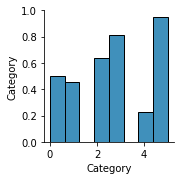

In [67]:
plt.figure(figsize=(20,10),dpi=500)
sns.pairplot(data = data)

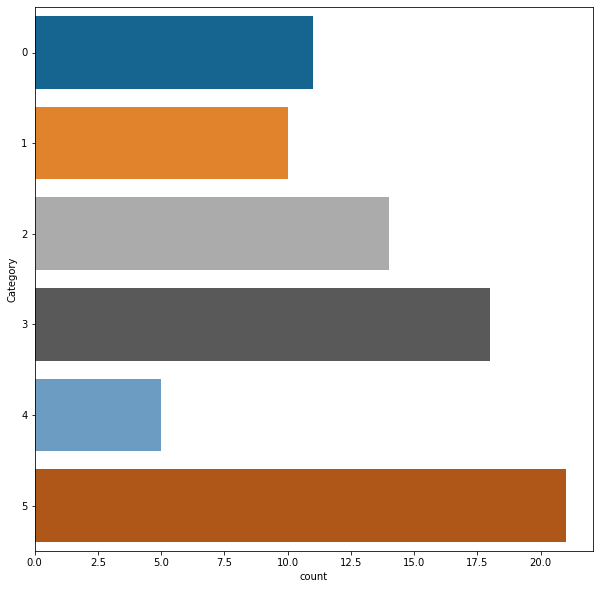

In [68]:
plt.figure(figsize=(10,10))
plt.xticks()
sns.countplot(y="Category", data=data)

In [69]:
targetCounts = data['Category'].value_counts().reset_index()['Category']
targetLabels  = data['Category'].value_counts().reset_index()['index']

In [70]:
targetCounts

0    21
1    18
2    14
3    11
4    10
5     5
Name: Category, dtype: int64

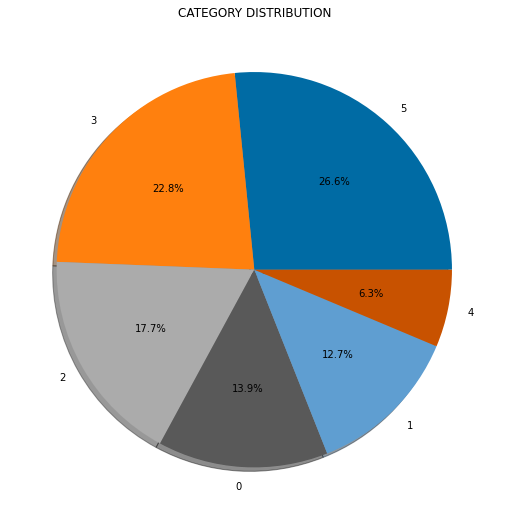

In [72]:
from matplotlib.gridspec import GridSpec
plt.figure(1, figsize=(20,20))
the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')
source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True)

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [74]:
requiredText = data['Absolute_Clean_Resumes'].values
requiredTarget = data['Category'].values

word_vectorizer = TfidfVectorizer(sublinear_tf=True,stop_words='english')
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(WordFeatures, requiredTarget, random_state=45, test_size=0.20,stratify=requiredTarget)
X_train.shape, X_test.shape

((63, 4547), (16, 4547))

In [76]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import f1_score,precision_score,confusion_matrix,recall_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Logistic Regression

In [77]:
lg = LogisticRegression()
lg.fit(X_train,y_train)

LogisticRegression()

In [78]:
predict1 = lg.predict(X_test)

In [79]:
accuracy_1 = accuracy_score(y_test,predict1)
accuracy_1

0.75

In [80]:
cm = confusion_matrix(y_test,predict1)
cm

array([[0, 0, 0, 2, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 0, 2, 1, 0, 0],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 4]])

Text(33.0, 0.5, 'Truth')

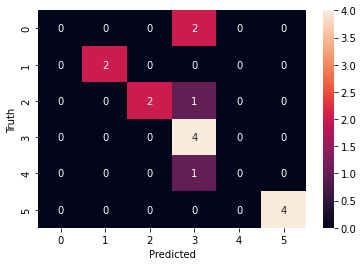

In [81]:
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [82]:
print(classification_report(y_test,predict1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         2
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         4
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         4

    accuracy                           0.75        16
   macro avg       0.58      0.61      0.58        16
weighted avg       0.69      0.75      0.69        16



In [83]:
accuracy_1 = round(accuracy_score(y_test,predict1),4)
precision_1 = round(precision_score(y_test,predict1,average = 'macro'),4)
recall_1 = round(recall_score(y_test,predict1, average = 'macro'),4)
f1_1 = round(f1_score(y_test,predict1, average = 'macro'),4)

In [84]:
print('Accuracy Score  : ', accuracy_1)
print('Precision Score : ', precision_1)
print('Recall Score    : ', recall_1)
print('f1-Score        : ', f1_1)

Accuracy Score  :  0.75
Precision Score :  0.5833
Recall Score    :  0.6111
f1-Score        :  0.5778


# Support Vector Machine Classifier(SVC)

In [85]:
sv = SVC()
sv.fit(X_train,y_train)
predict2 = sv.predict(X_test)

In [86]:
accuracy_2 = accuracy_score(y_test,predict2)
accuracy_2

0.6875

In [87]:
cm2 = confusion_matrix(y_test,predict2)
cm2

array([[0, 0, 0, 2, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 4]])

Text(33.0, 0.5, 'Truth')

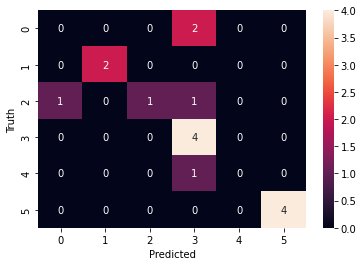

In [88]:
sns.heatmap(cm2,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [89]:
print(classification_report(y_test,predict2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         2
           2       1.00      0.33      0.50         3
           3       0.50      1.00      0.67         4
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         4

    accuracy                           0.69        16
   macro avg       0.58      0.56      0.53        16
weighted avg       0.69      0.69      0.64        16



In [90]:
accuracy_2 = round(accuracy_score(y_test,predict2),4)
precision_2 = round(precision_score(y_test,predict2,average = 'macro'),4)
recall_2 = round(recall_score(y_test,predict2, average = 'macro'),4)
f1_2 = round(f1_score(y_test,predict2, average = 'macro'),4)

In [91]:
print('Accuracy Score  : ', accuracy_2)
print('Precision Score : ', precision_2)
print('Recall Score    : ', recall_2)
print('f1-Score        : ', f1_2)

Accuracy Score  :  0.6875
Precision Score :  0.5833
Recall Score    :  0.5556
f1-Score        :  0.5278


# Random Forest Classifier

In [92]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
predict3=rf.predict(X_test)

In [93]:
accuracy_3 = accuracy_score(y_test,predict3)
accuracy_3

0.75

In [94]:
cm3 = confusion_matrix(y_test,predict3)
cm3

array([[0, 2, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [1, 0, 2, 0, 0, 0],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 4]])

Text(33.0, 0.5, 'Truth')

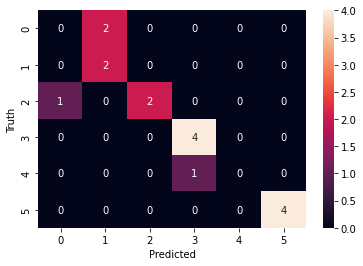

In [95]:
sns.heatmap(cm3,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [96]:
print(classification_report(y_test,predict3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         2
           2       1.00      0.67      0.80         3
           3       0.80      1.00      0.89         4
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         4

    accuracy                           0.75        16
   macro avg       0.55      0.61      0.56        16
weighted avg       0.70      0.75      0.71        16



In [97]:
accuracy_3 = round(accuracy_score(y_test,predict3),4)
precision_3 = round(precision_score(y_test,predict3,average = 'macro'),4)
recall_3 = round(recall_score(y_test,predict3, average = 'macro'),4)
f1_3 = round(f1_score(y_test,predict3, average = 'macro'),4)

print('Accuracy Score  : ', accuracy_3)
print('Precision Score : ', precision_3)
print('Recall Score    : ', recall_3)
print('f1-Score        : ', f1_3)

Accuracy Score  :  0.75
Precision Score :  0.55
Recall Score    :  0.6111
f1-Score        :  0.5593


# Naive-Bayes Classifier

In [98]:
nb=MultinomialNB()
nb.fit(X_train,y_train)
predict4=nb.predict(X_test)

In [99]:
accuracy_4 = accuracy_score(y_test,predict4)
accuracy_4

0.5

In [100]:
cm4=confusion_matrix(y_test,predict4)
cm4

array([[0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 2],
       [0, 0, 0, 1, 0, 2],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 4]])

Text(33.0, 0.5, 'Truth')

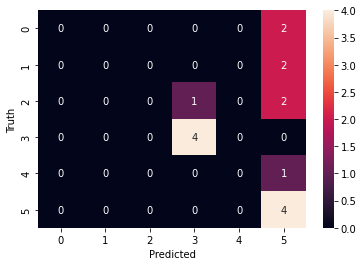

In [101]:
sns.heatmap(cm4,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [102]:
print(classification_report(y_test,predict4))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.80      1.00      0.89         4
           4       0.00      0.00      0.00         1
           5       0.36      1.00      0.53         4

    accuracy                           0.50        16
   macro avg       0.19      0.33      0.24        16
weighted avg       0.29      0.50      0.36        16



In [103]:
accuracy_4 = round(accuracy_score(y_test,predict4),4)
precision_4 = round(precision_score(y_test,predict4,average = 'macro'),4)
recall_4 = round(recall_score(y_test,predict4, average = 'macro'),4)
f1_4 = round(f1_score(y_test,predict4, average = 'macro'),4)

print('Accuracy Score  : ', accuracy_4)
print('Precision Score : ', precision_4)
print('Recall Score    : ', recall_4)
print('f1-Score        : ', f1_4)

Accuracy Score  :  0.5
Precision Score :  0.1939
Recall Score    :  0.3333
f1-Score        :  0.237


# Decision Tree Classifier

In [104]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train,y_train)
predict5=dt.predict(X_test)

In [105]:
accuracy_5 = accuracy_score(y_test,predict5)
accuracy_5

0.75

In [106]:
cm5=confusion_matrix(y_test,predict5)
cm5

array([[0, 1, 1, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0],
       [0, 0, 1, 3, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 4]])

Text(33.0, 0.5, 'Truth')

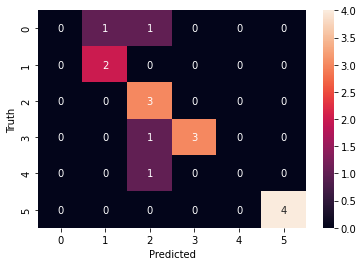

In [107]:
sns.heatmap(cm5,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [108]:
print(classification_report(y_test,predict5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         2
           2       0.50      1.00      0.67         3
           3       1.00      0.75      0.86         4
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         4

    accuracy                           0.75        16
   macro avg       0.53      0.62      0.55        16
weighted avg       0.68      0.75      0.69        16



In [109]:
accuracy_5 = round(accuracy_score(y_test,predict5),4)
precision_5 = round(precision_score(y_test,predict5,average = 'macro'),4)
recall_5 = round(recall_score(y_test,predict5, average = 'macro'),4)
f1_5 = round(f1_score(y_test,predict5, average = 'macro'),4)

print('Accuracy Score  : ', accuracy_5)
print('Precision Score : ', precision_5)
print('Recall Score    : ', recall_5)
print('f1-Score        : ', f1_5)

Accuracy Score  :  0.75
Precision Score :  0.5278
Recall Score    :  0.625
f1-Score        :  0.554


# AdaBoost Classifier

In [110]:
ab = AdaBoostClassifier()
ab.fit(X_train,y_train)
predict6=ab.predict(X_test)

In [111]:
accuracy_6 = accuracy_score(y_test,predict6)
accuracy_6

0.625

In [112]:
cm6 = confusion_matrix(y_test,predict6)
cm6

array([[0, 1, 0, 1, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 4]])

Text(33.0, 0.5, 'Truth')

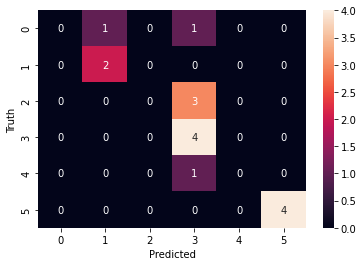

In [113]:
sns.heatmap(cm6,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [114]:
print(classification_report(y_test,predict6))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         2
           2       0.00      0.00      0.00         3
           3       0.44      1.00      0.62         4
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         4

    accuracy                           0.62        16
   macro avg       0.35      0.50      0.40        16
weighted avg       0.44      0.62      0.50        16



In [115]:
accuracy_6 = round(accuracy_score(y_test,predict6),4)
precision_6 = round(precision_score(y_test,predict6,average = 'macro'),4)
recall_6 = round(recall_score(y_test,predict6, average = 'macro'),4)
f1_6 = round(f1_score(y_test,predict6, average = 'macro'),4)

print('Accuracy Score  : ', accuracy_6)
print('Precision Score : ', precision_6)
print('Recall Score    : ', recall_6)
print('f1-Score        : ', f1_6)

Accuracy Score  :  0.625
Precision Score :  0.3519
Recall Score    :  0.5
f1-Score        :  0.4026


# GradientBoosting Classifier

In [116]:
gd = GradientBoostingClassifier()
gd.fit(X_train,y_train)
predict7 = gd.predict(X_test)

In [117]:
accuracy_7 = accuracy_score(y_test,predict7)
accuracy_7

0.6875

In [118]:
cm7 = confusion_matrix(y_test,predict7)
cm7

array([[0, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 2],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 4]])

Text(33.0, 0.5, 'Truth')

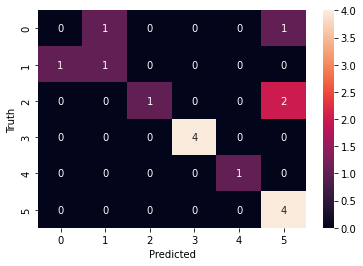

In [119]:
sns.heatmap(cm7,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [120]:
print(classification_report(y_test,predict7))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.50      0.50         2
           2       1.00      0.33      0.50         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       0.57      1.00      0.73         4

    accuracy                           0.69        16
   macro avg       0.68      0.64      0.62        16
weighted avg       0.71      0.69      0.65        16



In [121]:
accuracy_7 = round(accuracy_score(y_test,predict7),4)
precision_7 = round(precision_score(y_test,predict7,average = 'macro'),4)
recall_7 = round(recall_score(y_test,predict7, average = 'macro'),4)
f1_7 = round(f1_score(y_test,predict7, average = 'macro'),4)

print('Accuracy Score  : ', accuracy_7)
print('Precision Score : ', precision_7)
print('Recall Score    : ', recall_7)
print('f1-Score        : ', f1_7)

Accuracy Score  :  0.6875
Precision Score :  0.6786
Recall Score    :  0.6389
f1-Score        :  0.6212


# XGBoost Classifier

In [122]:
xg = XGBClassifier()
xg.fit(X_train,y_train)
predict8 = xg.predict(X_test)

In [123]:
accuracy_8 = accuracy_score(y_test,predict8)
accuracy_8

0.875

In [124]:
cm8 = confusion_matrix(y_test,predict8)
cm8

array([[1, 1, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [1, 0, 2, 0, 0, 0],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 4]])

Text(33.0, 0.5, 'Truth')

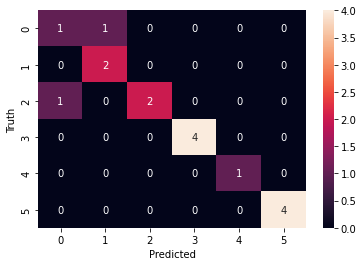

In [125]:
sns.heatmap(cm8,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [126]:
print(classification_report(y_test,predict8))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.67      1.00      0.80         2
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4

    accuracy                           0.88        16
   macro avg       0.86      0.86      0.85        16
weighted avg       0.90      0.88      0.88        16



In [127]:
accuracy_8 = round(accuracy_score(y_test,predict8),4)
precision_8 = round(precision_score(y_test,predict8,average = 'macro'),4)
recall_8 = round(recall_score(y_test,predict8, average = 'macro'),4)
f1_8 = round(f1_score(y_test,predict8, average = 'macro'),4)

print('Accuracy Score  : ', accuracy_8)
print('Precision Score : ', precision_8)
print('Recall Score    : ', recall_8)
print('f1-Score        : ', f1_8)

Accuracy Score  :  0.875
Precision Score :  0.8611
Recall Score    :  0.8611
f1-Score        :  0.85


# LGBM-Boosting Classifier

In [128]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
predict9 = lgbm.predict(X_test)

In [129]:
accuracy_9 = accuracy_score(y_test,predict9)
accuracy_9

0.8125

In [130]:
cm9 = confusion_matrix(y_test,predict9)
cm9

array([[1, 1, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [2, 0, 1, 0, 0, 0],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 4]])

Text(33.0, 0.5, 'Truth')

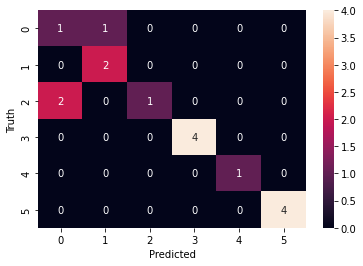

In [131]:
sns.heatmap(cm9,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [132]:
print(classification_report(y_test,predict9))

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.67      1.00      0.80         2
           2       1.00      0.33      0.50         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4

    accuracy                           0.81        16
   macro avg       0.83      0.81      0.78        16
weighted avg       0.88      0.81      0.81        16



In [133]:
accuracy_9 = round(accuracy_score(y_test,predict9),4)
precision_9 = round(precision_score(y_test,predict9,average = 'macro'),4)
recall_9 = round(recall_score(y_test,predict9, average = 'macro'),4)
f1_9 = round(f1_score(y_test,predict9, average = 'macro'),4)

print('Accuracy Score  : ', accuracy_9)
print('Precision Score : ', precision_9)
print('Recall Score    : ', recall_9)
print('f1-Score        : ', f1_9)

Accuracy Score  :  0.8125
Precision Score :  0.8333
Recall Score    :  0.8056
f1-Score        :  0.7833


In [134]:
table = {'Classifier' : ['Logistic Regression','SVM Classifier','Random Forest Classifier', 'Naive-Bayes Classifier','Decision Tree Classifier','AdaBoost Classifier', 'Gradient Boosting Classifier', 'Xtreme Gradient Boosting Classifier', 'Light Gradient Boosting Classifier'], 'Accuracy' : [accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5, accuracy_6, accuracy_7, accuracy_8, accuracy_9], 'Precision Score' : [precision_1, precision_2, precision_3, precision_4, precision_5, precision_6, precision_7, precision_8, precision_9], 'Recall Score' : [recall_1, recall_2, recall_3, recall_4, recall_5, recall_6, recall_7, recall_8, recall_9], 'F1_Score' : [f1_1, f1_2, f1_3, f1_4, f1_5, f1_6, f1_7, f1_8, f1_9]}
table = pd.DataFrame(table)
table.sort_values(["Accuracy"],inplace = True, ignore_index=True)
table

,Classifier,Accuracy,Precision Score,Recall Score,F1_Score
0,Naive-Bayes Classifier,0.5000,0.1939,0.3333,0.2370
1,AdaBoost Classifier,0.6250,0.3519,0.5000,0.4026
2,SVM Classifier,0.6875,0.5833,0.5556,0.5278
3,Gradient Boosting Classifier,0.6875,0.6786,0.6389,0.6212
4,Logistic Regression,0.7500,0.5833,0.6111,0.5778
5,Random Forest Classifier,0.7500,0.5500,0.6111,0.5593
6,Decision Tree Classifier,0.7500,0.5278,0.6250,0.5540
7,Light Gradient Boosting Classifier,0.8125,0.8333,0.8056,0.7833
8,Xtreme Gradient Boosting Classifier,0.8750,0.8611,0.8611,0.8500


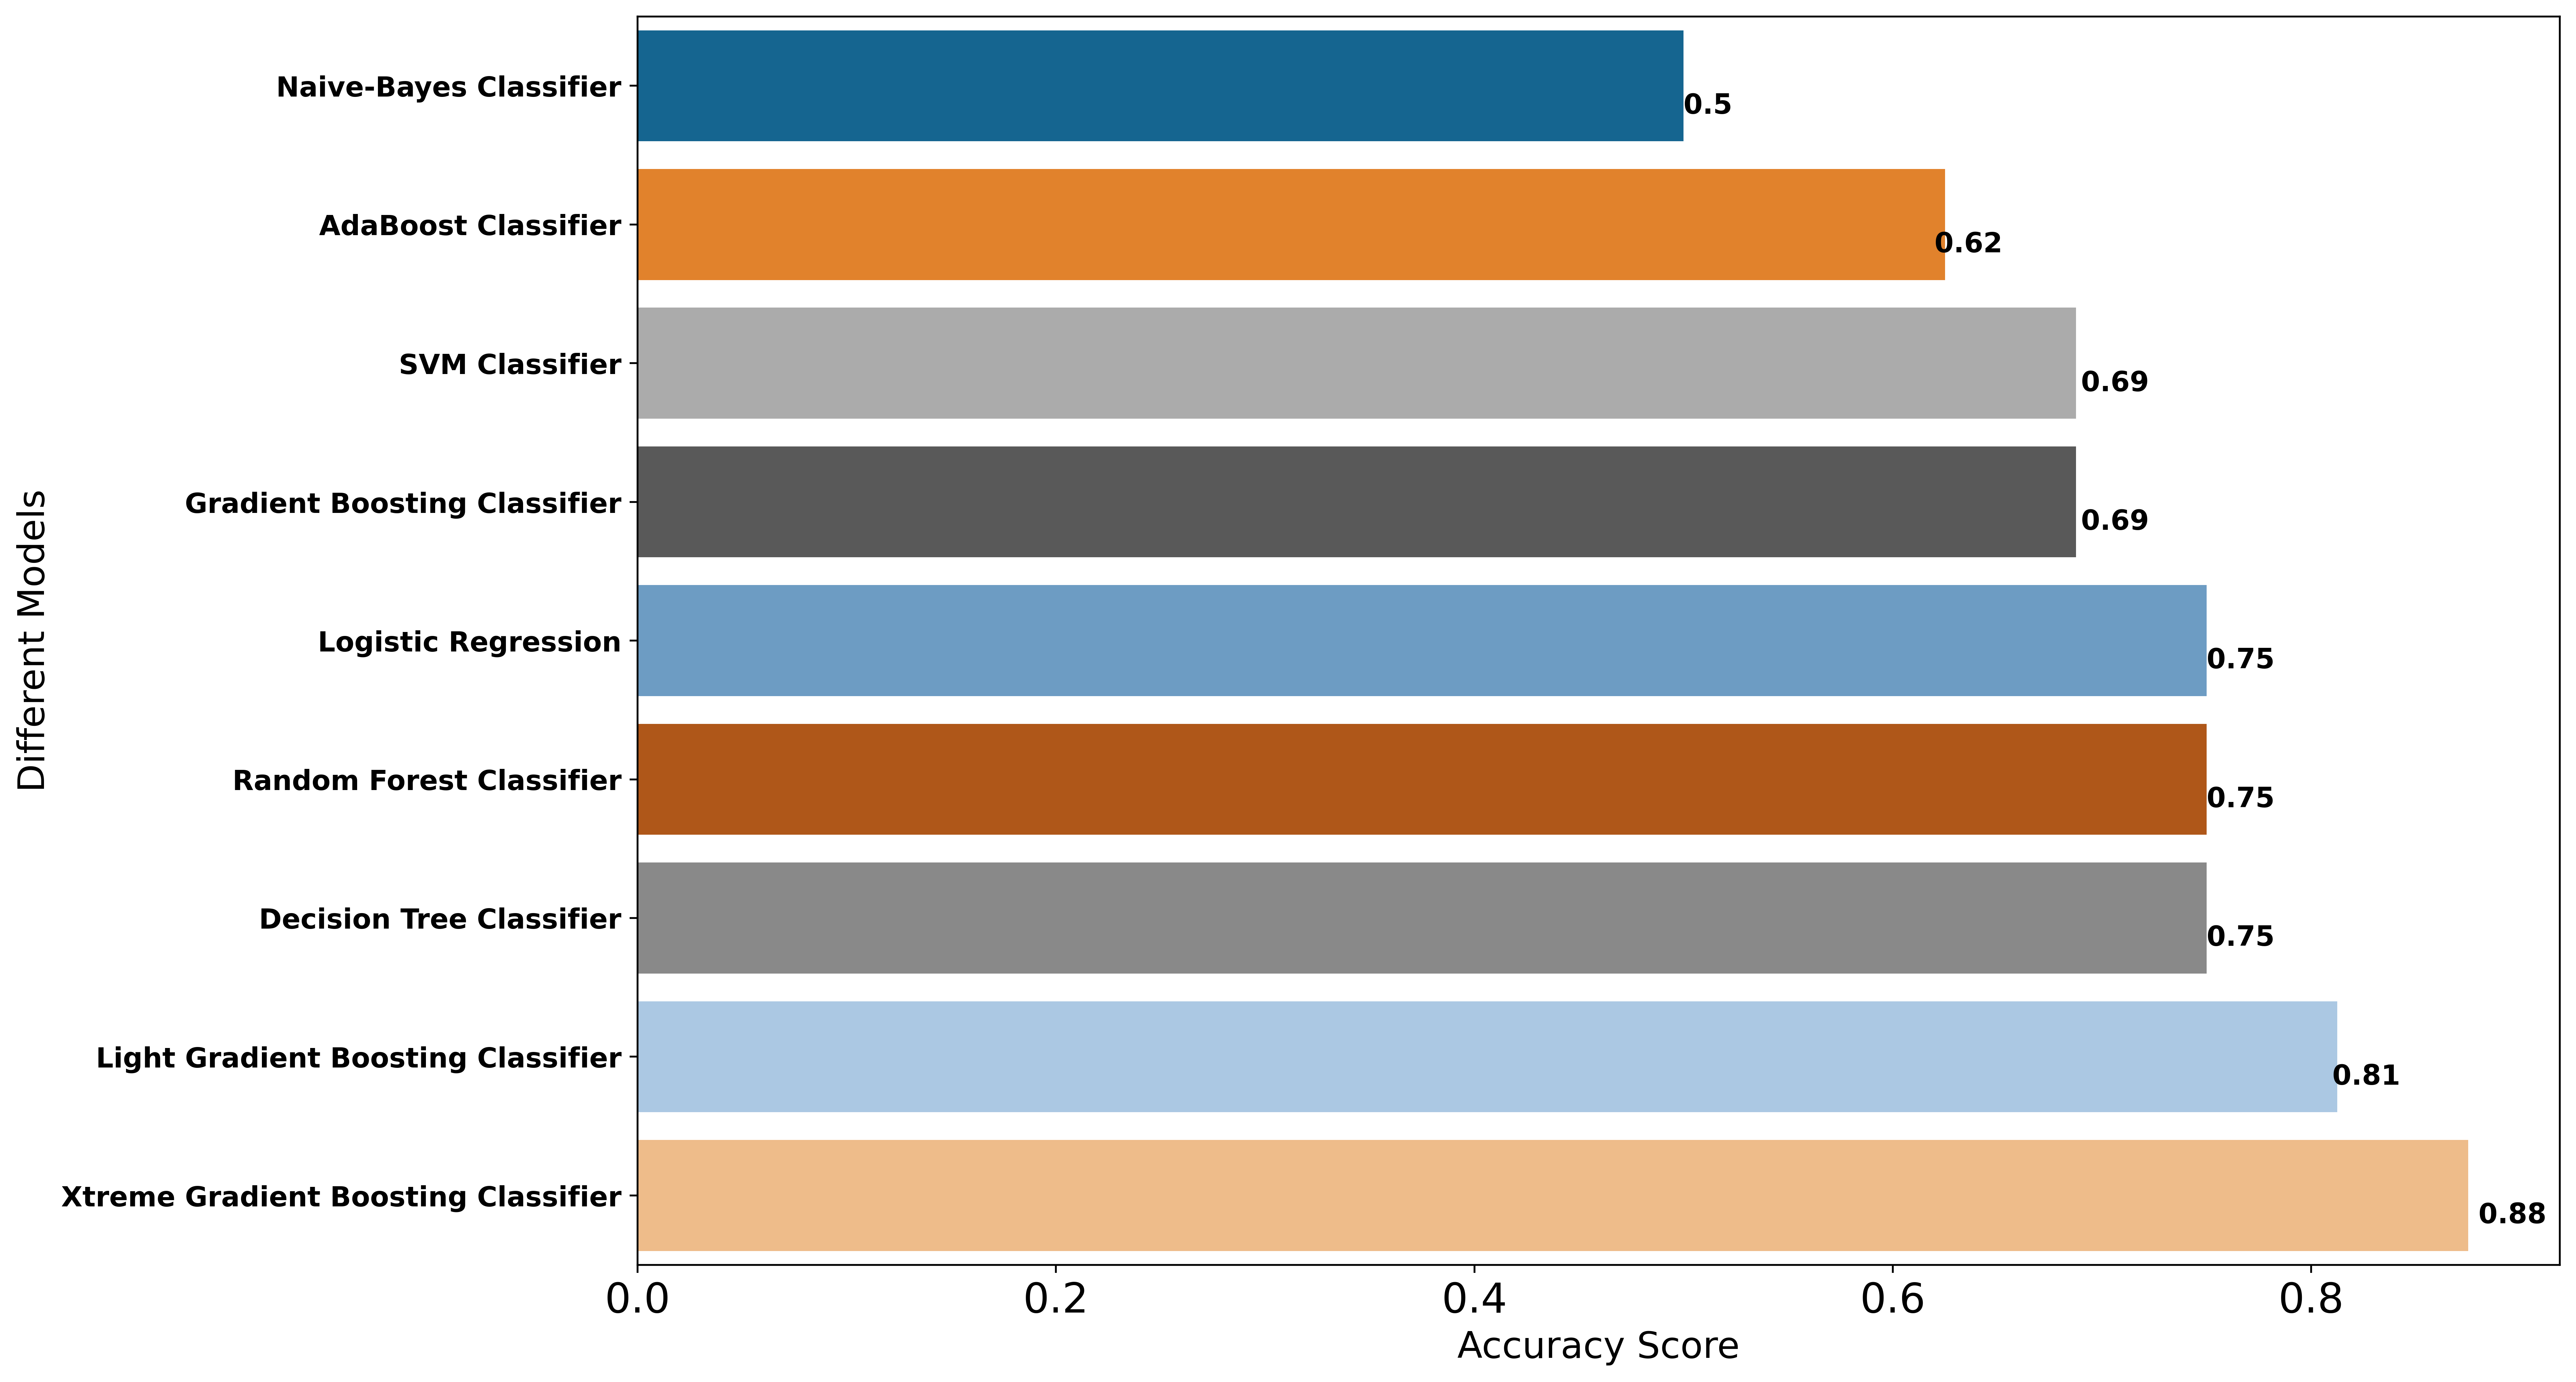

In [135]:
f,axe = plt.subplots(figsize=(15,10),dpi=500)
sns.barplot(x='Accuracy', y='Classifier', data=table, ax = axe)
axe.set_xlabel('Accuracy Score', size=16)
axe.set_ylabel('Different Models', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=18)

for i, v in enumerate(np.round(table.Accuracy.values,2)):
    axe.text(v + 0, i + .2, str(v),
            color = 'black', fontweight = 'bold', fontsize= 12)

plt.show()